#### Table of Contents
- [Prediction with Logistic Regression](#prediction-with-logistic-regression)
  - [1. Variable: Kills](#variable-kills)
    - [i. Data Preparation](#data-preparation)
    - [ii. Logistic Regression Model](#logistic-regression-model)
    - [iii. Data Visualisation](#data-visualisation)
  - [2. Variable: Towers](#variable-towers)
    - [i. Data Preparation](#data-preparation)
    - [ii. Logistic Regression Model](#logistic-regression-model)
    - [iii. Data Visualisation](#data-visualisation)
  
*Author: Oscar*

# Prediction with Logistic Regression

Now having analysed the kill statistics to some extent, perhaps we can use logistics regression to predict the outcome of a match. This is possible since our dependant variable is binary (win/lose) and we will be using 'x kills obtained before y minutes' as our independant variable

Import libraries

In [2]:
#import basic libraries
import warnings
import matplotlib.pyplot as plt
warnings.simplefilter(action='ignore', category=(FutureWarning, UserWarning, DeprecationWarning))
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from ast import literal_eval
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import math

---
## Variable: Kills

### Data Preparation
Here we will prepare and clean the dataset like in EDA. What is done here should be the same in EDA

In [3]:
# helper function to extract time of kill
def extract_time(x):
    try:
        return [x[0] for x in x]
    except:
        return [0 for x in x]

In [4]:
# Import Dataset
league_data = pd.read_csv("datasets/LeagueofLegends.csv")
kill_data = pd.read_csv('datasets/kills.csv')

# Make a copy of df to work with
clean_df = league_data.copy(deep=True)

# Make a new column to show winners
clean_df['winner'] = np.where(clean_df['bResult'] == 1, 1, 2)

# Convert columns with lists object to real lists
cols = ['bKills', 'rKills', 'goldblue', 'goldred', 'bTowers', 'rTowers', 'bInhibs', 'rInhibs', 'bDragons', 'rDragons', 'bBarons', 'rBarons', 'bHeralds', 'rHeralds', 'golddiff']

for col in cols:
    clean_df[col] = clean_df[col].apply(literal_eval)

# make new column for time of kills of each match
clean_df['bKills_time'] = clean_df['bKills'].apply(extract_time)
clean_df['rKills_time'] = clean_df['rKills'].apply(extract_time)

# each row now is the kill time of a specific map, for either blue or red team
kills_df = clean_df[['bKills_time', 'rKills_time']].unstack().apply(pd.Series)

# map address and winner to the df
_Address = dict(zip(clean_df.index, clean_df['Address']))
_winner = dict(zip(clean_df['Address'], clean_df['winner']))
kills_df['Address'] = kills_df.index.get_level_values(1)
kills_df['Address'] = kills_df['Address'].map(_Address)
kills_df['winner'] = kills_df.index.get_level_values(1)
kills_df['winner'] = kills_df['Address'].map(_winner)

# make index into column
kills_df = kills_df.reset_index(level=0, drop=False)
kills_df = kills_df.rename(columns={'level_0':'type'})

# melt df 
kills_melt = pd.melt(kills_df, id_vars=['Address', 'type', 'winner'], var_name='counts').fillna(0)

# boolean 'won' column if the match is won by the team
kills_melt['won'] = False
kills_melt.loc[((kills_melt['type']=='bKills_time') & (kills_melt['winner'] == 1)) | ((kills_melt['type']=='rKills_time') & (kills_melt['winner'] == 2)), 'won'] = True
kills_melt['counts']+=1

# categories time into bins
kills_melt['bin'] = pd.cut(kills_melt['value'], bins=np.arange(0,96,5))

# remove null value and seperate into win/lose
kills_all = kills_melt[kills_melt['bin'].notnull()]
kills_all = kills_all[kills_all['value'] >=1]

---
### Logistic Regression Model

Here we will split the dataset into train/test (7:3) and perform logistic regression with sklearn's LogisticRegression model

In [5]:
# before y minutes
Y_MINUTE = 5

kills_reg = kills_all.copy(deep=True)
kills_reg = kills_reg[kills_reg['value'] <= Y_MINUTE]

# X = pd.DataFrame(kills_reg['counts'])
# y = pd.DataFrame(kills_reg['won'])
X = kills_reg['counts'].values.reshape(-1,1)
y = kills_reg['won'].values.reshape(-1,1)
# y = kills_reg['won']

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# logistic regression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

prediction = logreg.predict(X_test)
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

       False       0.00      0.00      0.00       569
        True       0.64      1.00      0.78      1010

    accuracy                           0.64      1579
   macro avg       0.32      0.50      0.39      1579
weighted avg       0.41      0.64      0.50      1579



Looks like we are able to get a classification accuracy of ~63%

---
### Data Visualisation

Lets try to visualise this with matplotlib first

Intercept of regression line:  [-0.14389636]
Coefficient of regression line:  [[0.47423918]]


Text(0, 0.5, 'Winning Probability')

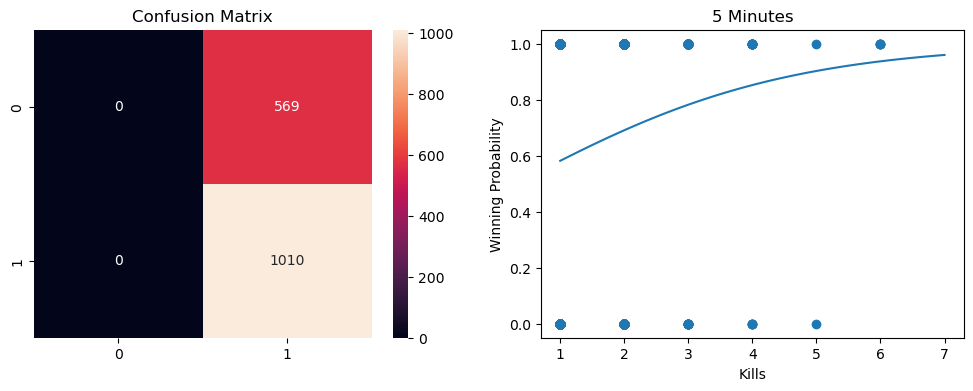

In [6]:
print('Intercept of regression line: ', logreg.intercept_)
print('Coefficient of regression line: ', logreg.coef_)
cm = confusion_matrix(y_test, logreg.predict(X_test))

# figure frame
f, ax = plt.subplots(1,2,figsize=(12,4))

# confusion matrix
p1 = plt.subplot2grid((1,2), (0,0))
sns.heatmap(data=cm, annot=True, fmt='.0f')
plt.title("Confusion Matrix")

# regression plot with matplotlib
p2 = plt.subplot2grid((1,2), (0,1))
plt.scatter(X_test,y_test)

#generate values for curve overlay
m = logreg.coef_[0,0]
b = logreg.intercept_[0]
lgs_curve = lambda x: 1/(1 + math.e**(-(m*x+b)))         
x_values = np.linspace(1, 7, 100)
y_values = lgs_curve(x_values)
plt.plot(x_values, y_values)
plt.title('5 Minutes')
plt.xlabel('Kills')
plt.ylabel('Winning Probability')

Now lets try using seaborn's lmplot which will be much easier

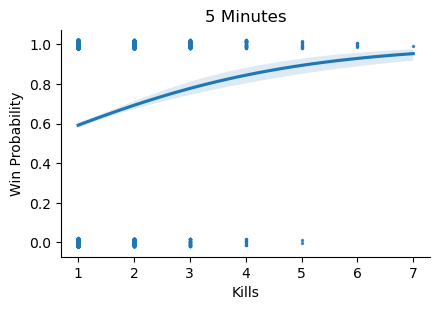

In [7]:
# lmplot with seaborn
sns.lmplot(data=kills_reg, x='counts', y='won', y_jitter=0.02, logistic=True, scatter_kws={'s': 2}, height=3, aspect=1.5)
plt.title('5 Minutes')
plt.ylabel('Win Probability')
plt.xlabel('Kills')
plt.show()

**Intepretation:**   
We can see that if a team gets 1 kill within the first 5 minute of the game, the chance of winning is around 60%. This chance of winning increases to >90% if the team manage to get >6 kills in the first 5 minutes of the game. This is logical since if a team is able to get >5 kills in the first 5 minutes, it is most likely that the entire team is winning the laning phase, and this means that if they can capitalise on the early advantage, then they are most likely to win the game    

Now, let's try to visualise this for other Y_MINUTE

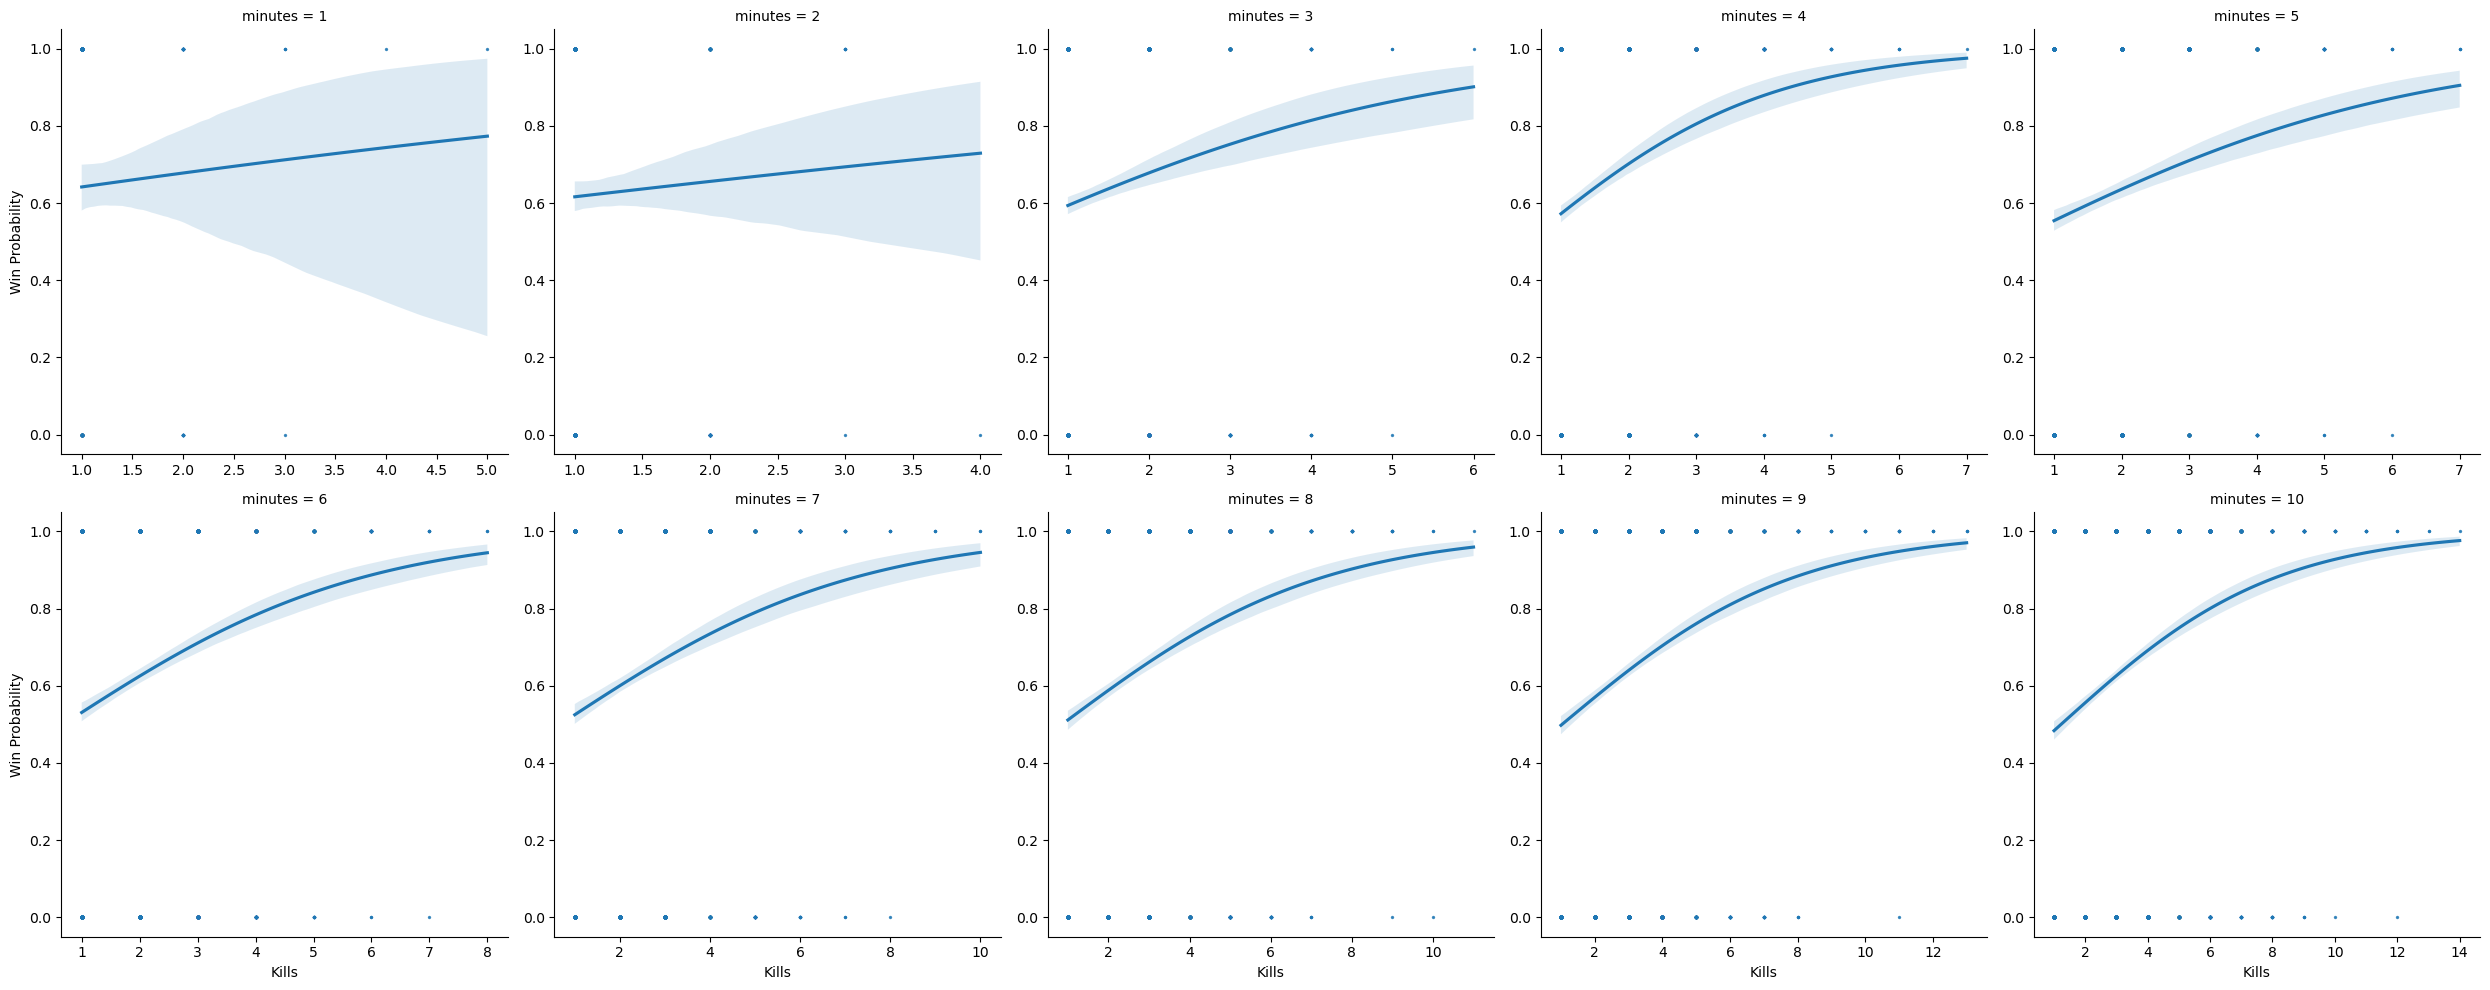

In [10]:
# before y minutes
Y_MINUTE = 10

kills_reg = kills_all.copy(deep=True)
kills_reg['minutes'] = kills_reg['value'].astype(int)
kills_reg = kills_reg[kills_reg['minutes'] <= Y_MINUTE]

p = sns.lmplot(data=kills_reg, x='counts', y='won',col='minutes', col_wrap=5, logistic=True, sharex=False, sharey=False, aspect=1, scatter_kws={'s':2})
p.set_xlabels('Kills')
p.set_ylabels('Win Probability')

**Comments:**   
A interesting observation is for graph of 'minute=1' and 'minute=2', every increase in number of kills in the first y minute of the game of leads to a very small increase in probability of winning the game. This could actually suggest that for META strategies such as early invasion of enemy's jungle, it might be a wiser decision to stop fighting after obtaining the first kill in game since the first kill can increase the probability of winning by around ~12% from 50%, while subsequent kills within the first 2 minutes in game only leads to marginal increase in the team's chance of winning.   

**Conclusion:**  
Possible strategy: It is important to get first kill in the first 2 minutes, but can stop fighting after the first kill is secured since the returns of subsequent kills is marginal. This is especially so for META strategies such as early invasion of enemy's jungle.Other than that, it is generally good to get kills early in the game as it can significantly boost your team's chance of winning.   

---

## Variable: Towers

We can try doing the same thing on any other variables. For now, lets try it on `towers takedown` to see if it can achieve a better classification accuracy. 

### Data Preparation

Here we will prepare the data in the same way as above, but for towers


In [62]:
# Import Dataset
structure_data = pd.read_csv('datasets/structures.csv')

# make new column for time of kills of each match
clean_df['bTowers_time'] = clean_df['bTowers'].apply(extract_time)
clean_df['rTowers_time'] = clean_df['rTowers'].apply(extract_time)

towers_df = clean_df[['bTowers_time', 'rTowers_time']].unstack().apply(pd.Series)

# map address and winner to the df
_Address = dict(zip(clean_df.index, clean_df['Address']))
_winner = dict(zip(clean_df['Address'], clean_df['winner']))
towers_df['Address'] = towers_df.index.get_level_values(1)
towers_df['Address'] = towers_df['Address'].map(_Address)
towers_df['winner'] = towers_df.index.get_level_values(1)
towers_df['winner'] = towers_df['Address'].map(_winner)

# make index into column
towers_df = towers_df.reset_index(level=0, drop=False)
towers_df = towers_df.rename(columns={'level_0':'type'})

# melt df 
towers_melt = pd.melt(towers_df, id_vars=['Address', 'type', 'winner'], var_name='counts').fillna(0)

# boolean 'won' column if the match is won by the team
towers_melt['won'] = False
towers_melt.loc[((towers_melt['type']=='bTowers_time') & (towers_melt['winner'] == 1)) | ((towers_melt['type']=='rTowers_time') & (towers_melt['winner'] == 2)), 'won'] = True
towers_melt['counts']+=1

# categories time into bins
towers_melt['bin'] = pd.cut(towers_melt['value'], bins=np.arange(0,96,5))

# remove null value and seperate into win/lose nad remove less than 5 min since that is a bit weird
towers_all = towers_melt[towers_melt['bin'].notnull()]
towers_all = towers_all[towers_all['value'] >=5]

In [63]:
towers_all

,Address,type,winner,counts,value,won,bin
0,http://matchhistory.na.leagueoflegends.com/en/...,bTowers_time,1,1,27.542,True,"(25, 30]"
1,http://matchhistory.na.leagueoflegends.com/en/...,bTowers_time,2,1,23.239,False,"(20, 25]"
2,http://matchhistory.na.leagueoflegends.com/en/...,bTowers_time,1,1,15.045,True,"(15, 20]"
3,http://matchhistory.na.leagueoflegends.com/en/...,bTowers_time,2,1,19.941,False,"(15, 20]"
4,http://matchhistory.na.leagueoflegends.com/en/...,bTowers_time,1,1,22.594,True,"(20, 25]"
...,...,...,...,...,...,...,...
198158,http://matchhistory.na.leagueoflegends.com/en/...,bTowers_time,1,14,12.389,True,"(10, 15]"
207818,http://matchhistory.na.leagueoflegends.com/en/...,rTowers_time,2,14,32.001,True,"(30, 35]"
213362,http://matchhistory.na.leagueoflegends.com/en/...,bTowers_time,1,15,29.505,True,"(25, 30]"
213398,http://matchhistory.na.leagueoflegends.com/en/...,bTowers_time,1,15,38.314,True,"(35, 40]"


---
### Logistic Regression Model

Here we will split the dataset into train/test (7:3) and perform logistic regression with sklearn's LogisticRegression model

In [65]:
# before y minutes
Y_MINUTE = 15
towers_reg = towers_all.copy(deep=True)
towers_reg = towers_reg[towers_reg['value'] <= Y_MINUTE]

X = towers_reg['counts'].values.reshape(-1,1)
y = towers_reg['won'].values.reshape(-1,1)

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# logistic regression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

prediction = logreg.predict(X_test)
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

       False       0.60      0.60      0.60      1442
        True       0.77      0.77      0.77      2531

    accuracy                           0.71      3973
   macro avg       0.69      0.69      0.69      3973
weighted avg       0.71      0.71      0.71      3973



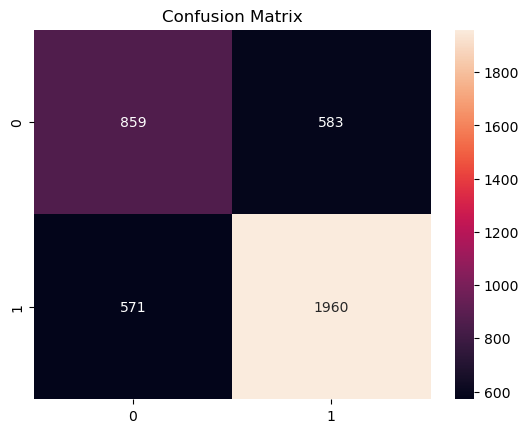

In [66]:
cm = confusion_matrix(y_test, logreg.predict(X_test))
sns.heatmap(data=cm, annot=True, fmt='.0f')
plt.title("Confusion Matrix")
plt.show()

Looks like towers seems to be a better variable to predict for out come of a game since we are about to get a classification accuracy of ~71% here

---

### Data Visualisation

We will visualise the logistic regression here too

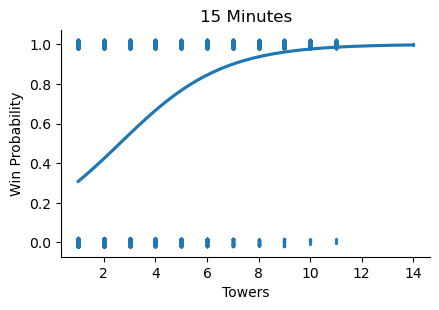

In [67]:
# lmplot with seaborn
sns.lmplot(data=towers_reg, x='counts', y='won', y_jitter=0.02, logistic=True, scatter_kws={'s': 2}, height=3, aspect=1.5)
plt.title('15 Minutes')
plt.ylabel('Win Probability')
plt.xlabel('Towers')
plt.show()

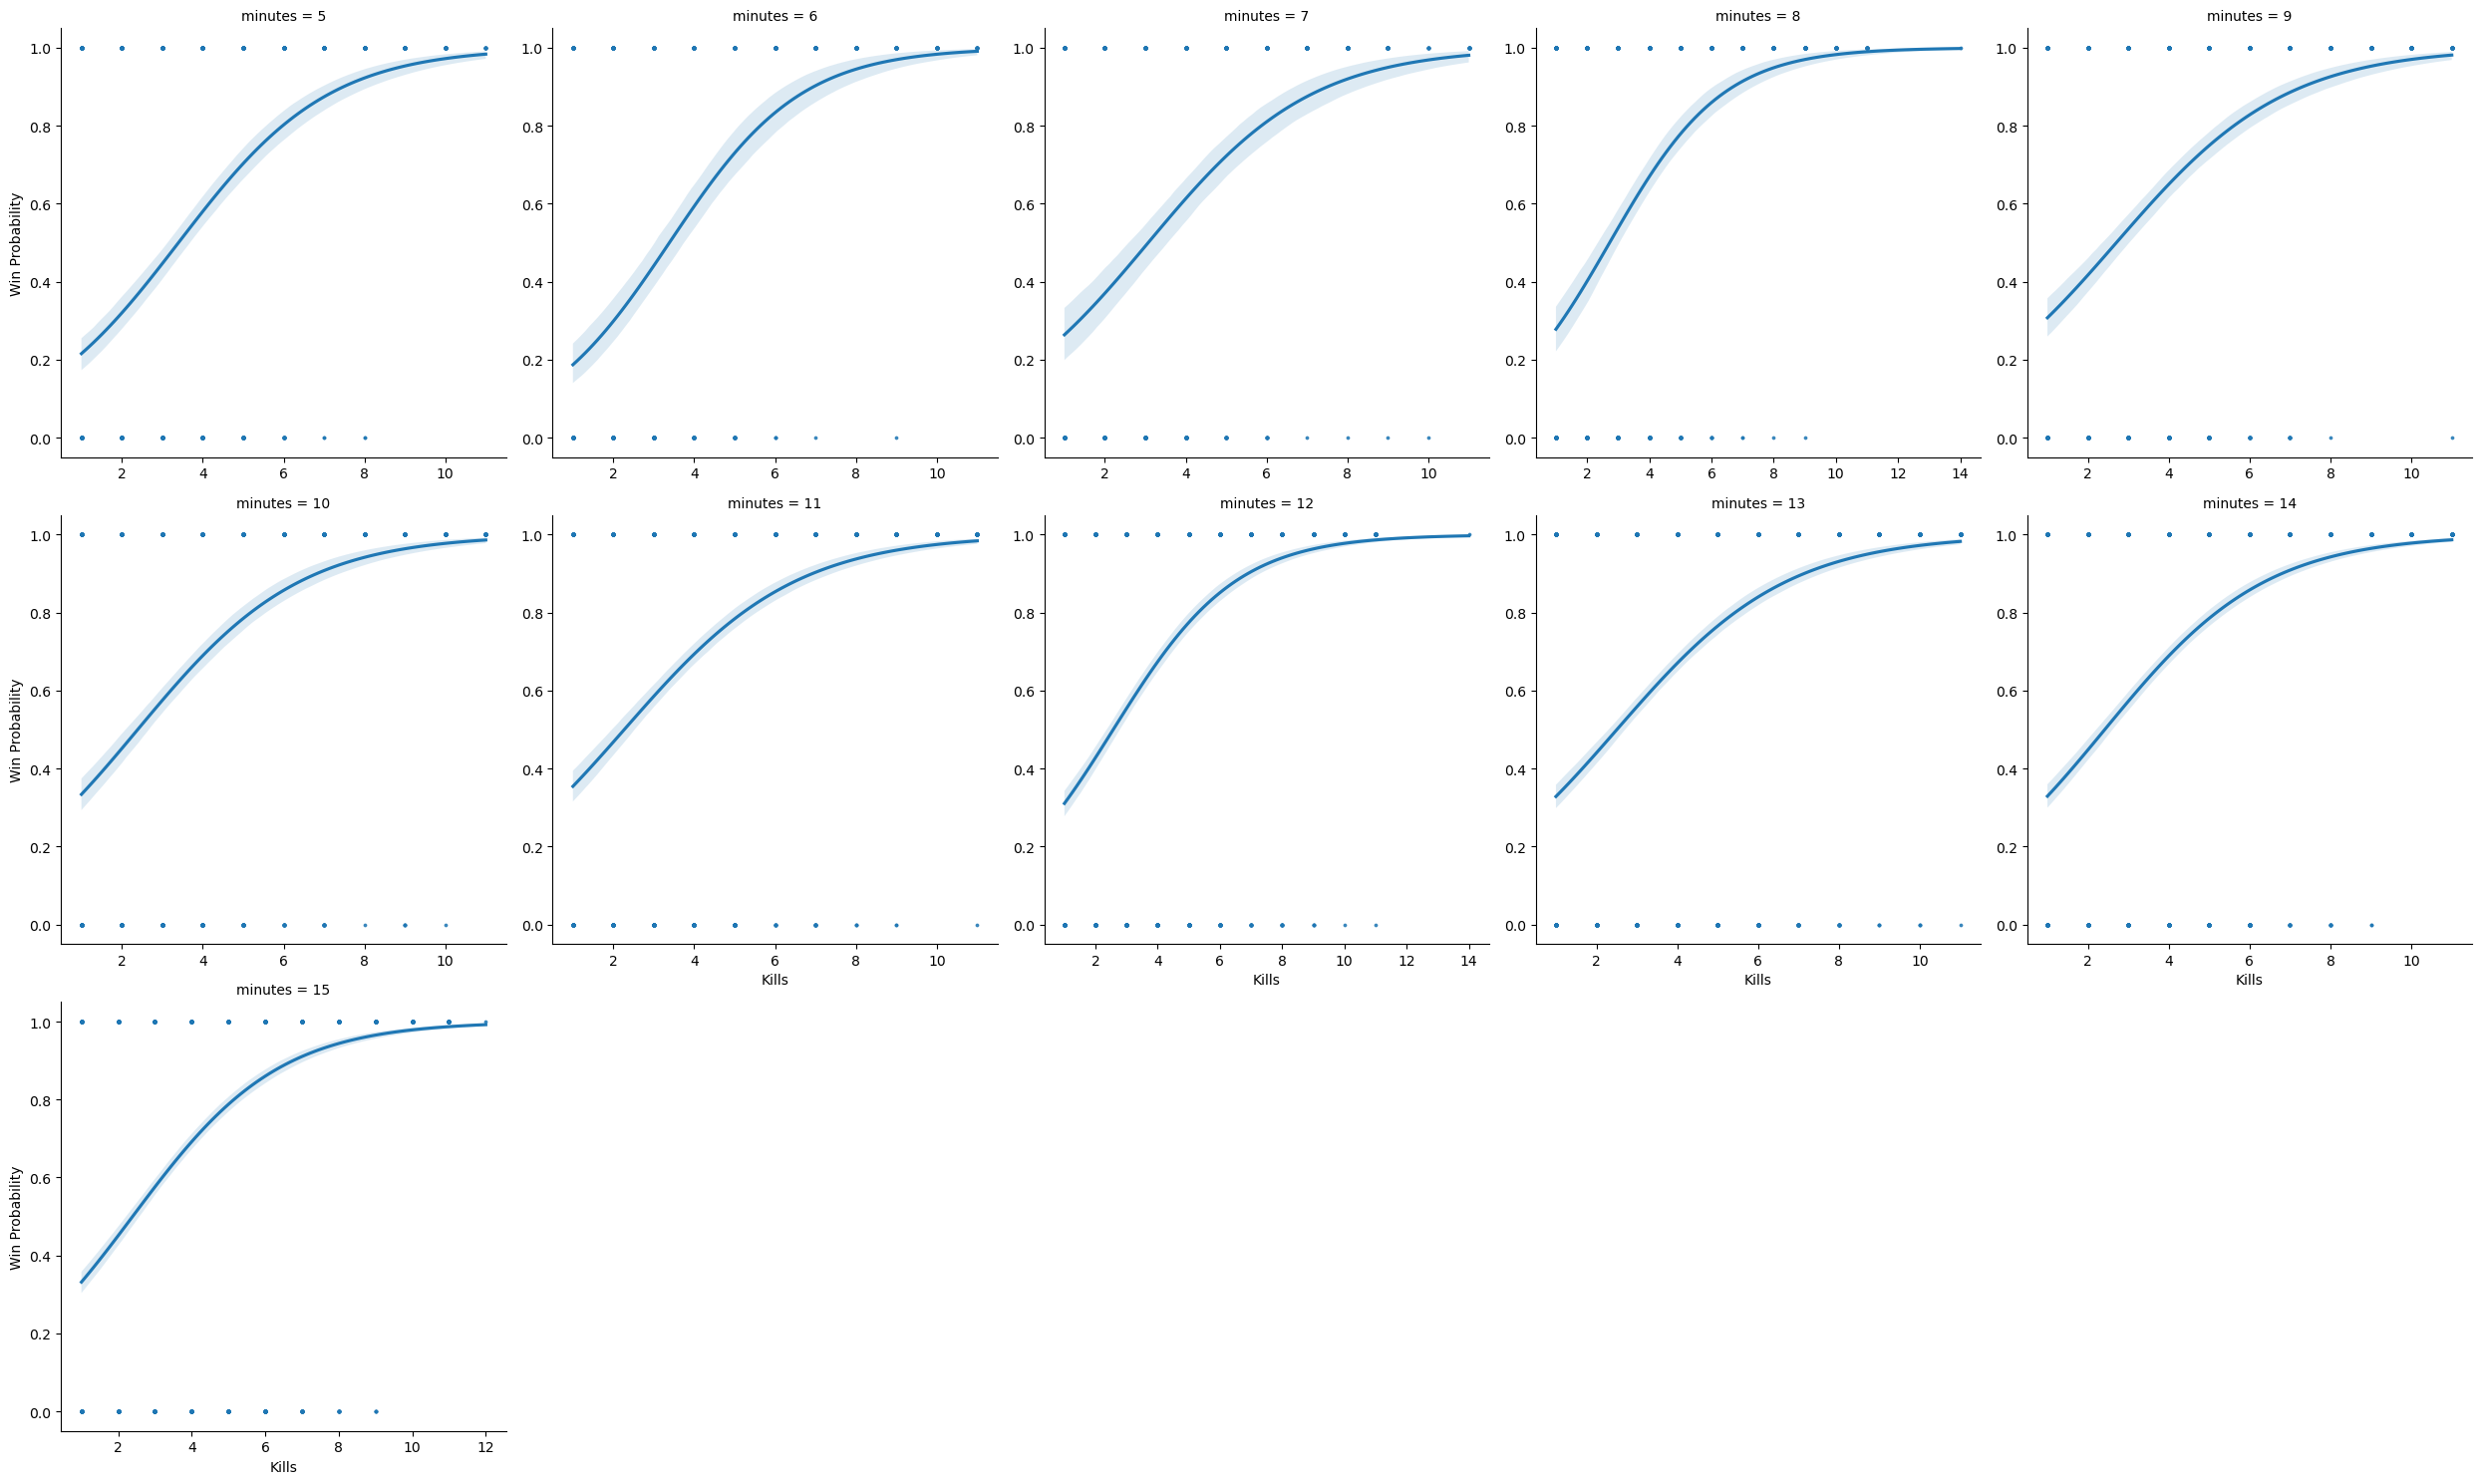

In [68]:
# before y minutes
Y_MINUTE = 15

towers_reg = towers_all.copy(deep=True)
towers_reg['minutes'] = towers_reg['value'].astype(int)
towers_reg = towers_reg[towers_reg['minutes'] <= Y_MINUTE]

p = sns.lmplot(data=towers_reg, x='counts', y='won',col='minutes', col_wrap=5, logistic=True, sharex=False, sharey=False, aspect=1, scatter_kws={'s':3})
p.set_xlabels('Kills')
p.set_ylabels('Win Probability')

**Comments:**   
Now looking at the 5 minutes graph, a interesting thing here is that in contrast to Kills is that taking down 1 turret before 5 minutes actually results in a lower probability of winning. The probability of winning only becomes >50% after getting 3 tower takedowns. This is indeed a extremely weird sight. 

Using Logistic Regression, we are only able to get a accuracy of ~64% for kills variable and slightly better, ~77% for towers variable. Moreover, it only takes into account of 1 attribute in the game at a time. Hence, we should seek for better models to predict outcome of the game   

---
Continue in `Champions_Analysis.ipynb`